In [1]:
# Steps to preprocess data

# remove all features which underwent embedding
# remove features (admitdate)
# OHE for admission_type, admission_location, insurance, marital_status
# choose either readmitted_30 or readmitted_60 or days_to_next_admission
# currently, if next admission is not present, then days_to_next_admission is not an integer -- need to convert to -1

In [2]:
# Check if CUDA is installed
import torch
print(torch.cuda.is_available())

True


In [2]:
# Imports
import pickle
import torch
from transformers import BertTokenizer, BertModel

c:\Users\James\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\James\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\James\AppData\Local\Pro

In [3]:
# Load data
X_filePath = '../../../data/processedData/X_Admin_Targets.pkl'
with open(X_filePath, 'rb') as f:
    data = pickle.load(f)

In [4]:
def explore_nested_dict(data, top_key):
    if top_key in data:
        nested_dict = data[top_key]
        print(f"Top-level Key: {top_key}")
        print(f"Keys in nested dictionary: {len(nested_dict.keys())}")
        
        # Inspect one of the nested keys in detail
        for nested_key in nested_dict:
            print(f"\nNested Key: {nested_key}")
            print(f"Type of value: {type(nested_dict[nested_key])}")
            print(f"Value sample: {nested_dict[nested_key]}")
    else:
        print(f"Key {top_key} not found in the data.")


top_key_to_inspect = 15496609

explore_nested_dict(data, top_key_to_inspect)

Top-level Key: 15496609
Keys in nested dictionary: 237

Nested Key: 20495098
Type of value: <class 'dict'>
Value sample: {'diagnoses': ['d_305'], 'procedures': [], 'drugs': [], 'admitdate': '2154-08-06', 'timespent': 8, 'admission_type': 'EU OBSERVATION', 'admission_location': 'EMERGENCY ROOM', 'insurance': 'Medicaid', 'marital_status': 'SINGLE', 'hospital_expire_flag': 0, 'days_to_next_admission': 242.59930555555556, 'readmitted_30': 0, 'readmitted_60': 0}

Nested Key: 29558470
Type of value: <class 'dict'>
Value sample: {'diagnoses': ['d_780', 'd_305'], 'procedures': ['pcs_870', 'pcs_893'], 'drugs': [], 'admitdate': '2155-04-05', 'timespent': 10, 'admission_type': 'EU OBSERVATION', 'admission_location': 'EMERGENCY ROOM', 'insurance': 'Medicaid', 'marital_status': 'SINGLE', 'hospital_expire_flag': 0, 'days_to_next_admission': 22.397916666666667, 'readmitted_30': 1, 'readmitted_60': 1}

Nested Key: 27670095
Type of value: <class 'dict'>
Value sample: {'diagnoses': ['d_780', 'd_305', 'd

In [5]:
from gensim.models import Word2Vec

# Step 1: Extract drugs, diagnoses, and procedures sequences
corpus = []  # This will hold all sequences for Word2Vec training
for subject_id, nested_dict in data.items():
    for hadm_id, record in nested_dict.items():
        # Combine drugs, diagnoses, and procedures into a single sequence
        sequence = record.get('drugs', []) + record.get('diagnoses', []) + record.get('procedures', [])
        corpus.append(sequence)

print("Sample Corpus:", corpus[:2])  # Check the first two sequences


Sample Corpus: [['p_NACLFLUSH', 'p_SPIR25', 'p_RALT400', 'p_ALBU17H', 'p_FURO20', 'p_MICROK10', 'p_NICO14P', 'p_HEPA5I', 'p_SPIR25', 'p_IPRA2H', 'p_INFL0.5LF', 'p_TRUV200/300', 'p_FURO40', 'p_APAP500', 'd_572', 'd_789', 'd_571', 'd_070', 'd_496', 'd_296', 'd_309', 'pcs_549'], ['p_BACTDS', 'p_TIOT', 'p_RIFA550', 'p_APAP500', 'p_ALBU25', 'p_NACLFLUSH', 'p_RALT400', 'p_HEPA5I', 'p_TRUV200/300', 'p_CAL1250', 'p_FURO40', 'p_INFL0.5LF', 'p_FURO20', 'p_ALBU17H', 'p_LACT30L', 'd_070', 'd_789', 'd_287', 'd_276', 'd_496', 'd_571', 'd_305', 'pcs_549']]


In [6]:
# Train Word2Vec model on the prepared corpus
# w2v_model = Word2Vec(
#     sentences=corpus, 
#     vector_size=100,  # Embedding size
#     window=5,  # Context window size
#     min_count=1,  # Include all tokens
#     workers=4,  # Number of parallel threads
#     sg=1  # Skip-gram model (set sg=0 for CBOW)
# )

# # Save and reload the model
# w2v_model.save("w2v_model_drugs_diagnoses_procedures.model")
w2v_model = Word2Vec.load("w2v_model_drugs_diagnoses_procedures.model")

# Check the vocabulary
print("Vocabulary size:", len(w2v_model.wv.index_to_key))


Vocabulary size: 5145


In [7]:
import numpy as np

def embed_features_separately(record, w2v_model, embed_size=100):
    """
    Generate embeddings for drugs, diagnoses, and procedures separately.
    Keeps embeddings for each item as-is (no averaging).
    """
    def embed_items(items):
        # Get embeddings for all items that exist in the Word2Vec vocabulary
        return [w2v_model.wv[item] for item in items if item in w2v_model.wv]

    # Generate embeddings for each feature type
    drugs_embeddings = embed_items(record.get('drugs', []))
    diagnoses_embeddings = embed_items(record.get('diagnoses', []))
    procedures_embeddings = embed_items(record.get('procedures', []))

    return drugs_embeddings, diagnoses_embeddings, procedures_embeddings

# Add embeddings to the data structure
for subject_id, nested_dict in data.items():
    for hadm_id, record in nested_dict.items():
        drugs_emb, diagnoses_emb, procedures_emb = embed_features_separately(record, w2v_model)
        record['drugs_embeddings'] = drugs_emb  # List of embeddings for drugs
        record['diagnoses_embeddings'] = diagnoses_emb  # List of embeddings for diagnoses
        record['procedures_embeddings'] = procedures_emb  # List of embeddings for procedures

print("Separate embeddings added successfully!")


Separate embeddings added successfully!


In [8]:
explore_nested_dict(data, top_key_to_inspect)

Top-level Key: 15496609
Keys in nested dictionary: 237

Nested Key: 20495098
Type of value: <class 'dict'>
Value sample: {'diagnoses': ['d_305'], 'procedures': [], 'drugs': [], 'admitdate': '2154-08-06', 'timespent': 8, 'admission_type': 'EU OBSERVATION', 'admission_location': 'EMERGENCY ROOM', 'insurance': 'Medicaid', 'marital_status': 'SINGLE', 'hospital_expire_flag': 0, 'days_to_next_admission': 242.59930555555556, 'readmitted_30': 0, 'readmitted_60': 0, 'drugs_embeddings': [], 'diagnoses_embeddings': [array([-0.10797549,  0.09013695,  0.36448544,  0.11244285, -0.13604361,
       -0.23893277,  0.33058426,  0.38535762,  0.37226385,  0.02764183,
       -0.11945215, -0.00701047, -0.03974198,  0.03633882, -0.01103153,
       -0.13631785, -0.13595368, -0.5043342 , -0.09810027, -0.00632857,
        0.2855311 ,  0.5149291 , -0.32125437,  0.14395845, -0.10392574,
        0.19340357, -0.5629908 , -0.13536778, -0.33691153, -0.01972994,
        0.44696838,  0.25051427, -0.3674987 ,  0.06848973

In [9]:
for subject_id, nested_dict in data.items():
    for hadm_id, record in nested_dict.items():
        record.pop('days_to_next_admission', None)
        record.pop('readmitted_60', None)
        record.pop('admitdate', None)
        record.pop('drugs', None)
        record.pop('diagnoses', None)
        record.pop('procedures', None)



In [10]:
explore_nested_dict(data, top_key_to_inspect)

Top-level Key: 15496609
Keys in nested dictionary: 237

Nested Key: 20495098
Type of value: <class 'dict'>
Value sample: {'timespent': 8, 'admission_type': 'EU OBSERVATION', 'admission_location': 'EMERGENCY ROOM', 'insurance': 'Medicaid', 'marital_status': 'SINGLE', 'hospital_expire_flag': 0, 'readmitted_30': 0, 'drugs_embeddings': [], 'diagnoses_embeddings': [array([-0.10797549,  0.09013695,  0.36448544,  0.11244285, -0.13604361,
       -0.23893277,  0.33058426,  0.38535762,  0.37226385,  0.02764183,
       -0.11945215, -0.00701047, -0.03974198,  0.03633882, -0.01103153,
       -0.13631785, -0.13595368, -0.5043342 , -0.09810027, -0.00632857,
        0.2855311 ,  0.5149291 , -0.32125437,  0.14395845, -0.10392574,
        0.19340357, -0.5629908 , -0.13536778, -0.33691153, -0.01972994,
        0.44696838,  0.25051427, -0.3674987 ,  0.06848973, -0.58059704,
        0.3674139 , -0.07012863, -0.7047052 , -0.10550993, -0.17846577,
        0.32101753, -0.44342726, -0.1059443 , -0.3077568 ,  0

In [11]:
from collections import defaultdict
import numpy as np

# Step 1: Find all unique categories for each field
unique_categories = defaultdict(set)
fields_to_encode = ["admission_type", "admission_location", "insurance", "marital_status"]

for subject_id, nested_dict in data.items():
    for hadm_id, record in nested_dict.items():
        for field in fields_to_encode:
            if field in record:
                value = record[field]
                if value is None:
                    value = "UNKNOWN"  # Handle null values
                value = str(value)  # Ensure all values are strings
                unique_categories[field].add(value)

# Step 2: Create a mapping from category to index
category_to_index = {
    field: {category: i for i, category in enumerate(sorted(categories))}
    for field, categories in unique_categories.items()
}

# Step 3: Replace string values with one-hot encoded vectors
for subject_id, nested_dict in data.items():
    for hadm_id, record in nested_dict.items():
        for field in fields_to_encode:
            if field in record:
                value = record[field]
                if value is None:
                    value = "UNKNOWN"  # Handle null values
                value = str(value)  # Ensure value is a string
                # Get the index for the category
                index = category_to_index[field][value]
                # Create a one-hot encoded vector
                ohe_vector = np.zeros(len(category_to_index[field]), dtype=int)
                ohe_vector[index] = 1
                # Replace the original string value with the one-hot vector
                record[field] = ohe_vector

# Confirmation message
print("One-hot encoding completed successfully.")


One-hot encoding completed successfully.


In [12]:
explore_nested_dict(data, top_key_to_inspect)


Top-level Key: 15496609
Keys in nested dictionary: 237

Nested Key: 20495098
Type of value: <class 'dict'>
Value sample: {'timespent': 8, 'admission_type': array([0, 0, 0, 0, 1, 0, 0, 0, 0]), 'admission_location': array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]), 'insurance': array([1, 0, 0]), 'marital_status': array([0, 0, 1, 0, 0]), 'hospital_expire_flag': 0, 'readmitted_30': 0, 'drugs_embeddings': [], 'diagnoses_embeddings': [array([-0.10797549,  0.09013695,  0.36448544,  0.11244285, -0.13604361,
       -0.23893277,  0.33058426,  0.38535762,  0.37226385,  0.02764183,
       -0.11945215, -0.00701047, -0.03974198,  0.03633882, -0.01103153,
       -0.13631785, -0.13595368, -0.5043342 , -0.09810027, -0.00632857,
        0.2855311 ,  0.5149291 , -0.32125437,  0.14395845, -0.10392574,
        0.19340357, -0.5629908 , -0.13536778, -0.33691153, -0.01972994,
        0.44696838,  0.25051427, -0.3674987 ,  0.06848973, -0.58059704,
        0.3674139 , -0.07012863, -0.7047052 , -0.10550993, -0.17846577,

In [13]:
top_key_to_inspect = 10000032

explore_nested_dict(data, top_key_to_inspect)

Top-level Key: 10000032
Keys in nested dictionary: 3

Nested Key: 22595853
Type of value: <class 'dict'>
Value sample: {'timespent': 18, 'admission_type': array([0, 0, 0, 0, 0, 0, 0, 0, 1]), 'admission_location': array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]), 'insurance': array([0, 0, 1]), 'marital_status': array([0, 0, 0, 1, 0]), 'hospital_expire_flag': 0, 'readmitted_30': 0, 'drugs_embeddings': [array([-0.18121926,  0.23991662,  0.25093687, -0.04108852,  0.13478015,
       -0.17816225,  0.2147137 , -0.09637608, -0.12782027, -0.21047361,
       -0.29731494,  0.09859569,  0.10851665,  0.06178497,  0.20540096,
       -0.31534836, -0.42860568,  0.06657241, -0.12525624,  0.05456026,
        0.03836492, -0.02442078, -0.08686718,  0.20498791,  0.03162985,
       -0.1296841 ,  0.15639605, -0.24047668, -0.09574793, -0.07322566,
       -0.0423634 ,  0.02281875,  0.13035816,  0.21072493, -0.22872   ,
        0.16809349, -0.04423755,  0.35886547,  0.02363588, -0.05979146,
       -0.13152637, -0.01299

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [15]:
# Data Preparation Function
def prepare_data_for_sequential_rnn(data_dict):
    sequences = []  # Holds sequences of admissions for each patient
    labels = []     # Holds readmitted_30 labels for each admission

    for subject_id, admissions in data_dict.items():
        patient_sequence = []
        patient_labels = []
        for hadm_id, features in admissions.items():
            # Combine features into a single vector
            feature_vector = np.concatenate([
                [features['timespent']],  # Numerical feature
                features['admission_type'],  # Categorical (OHE)
                features['admission_location'],  # Categorical (OHE)
                features['insurance'],  # Categorical (OHE)
                features['marital_status'],  # Categorical (OHE)
                [features['hospital_expire_flag']],  # Binary
                np.mean(features['diagnoses_embeddings'], axis=0) if features['diagnoses_embeddings'] else np.zeros(100),
                np.mean(features['drugs_embeddings'], axis=0) if features['drugs_embeddings'] else np.zeros(100),
                np.mean(features['procedures_embeddings'], axis=0) if features['procedures_embeddings'] else np.zeros(100),
            ])
            patient_sequence.append(feature_vector)
            patient_labels.append(features['readmitted_30'])
        
        sequences.append(patient_sequence)
        labels.append(patient_labels)

    # Pad sequences for consistent input dimensions
    padded_sequences = pad_sequences(sequences, padding='post', dtype='float32')
    padded_labels = pad_sequences(labels, padding='post', value=0)  # Use 0 for padding labels

    return padded_sequences, padded_labels

In [16]:
# Prepare the data
sequences, labels = prepare_data_for_sequential_rnn(data)
print("Sequences shape:", sequences.shape)  # (patients, max_admissions, features_per_admission)
print("Labels shape:", labels.shape)        # (patients, max_admissions)


Sequences shape: (43814, 237, 330)
Labels shape: (43814, 237)


In [17]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)

y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)


In [18]:
import tensorflow as tf

# Check if TensorFlow is using the GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)

# Test computation on GPU
with tf.device('/GPU:0'):
    a = tf.constant([[1.0, 2.0, 3.0]])
    b = tf.constant([[4.0], [5.0], [6.0]])
    c = tf.matmul(a, b)
    print(c)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPU.")
    except RuntimeError as e:
        print(e)


Num GPUs Available:  0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:CPU:0
tf.Tensor([[32.]], shape=(1, 1), dtype=float32)


In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, TimeDistributed

def build_rnn_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Masking(mask_value=0.0, input_shape=input_shape),  # Mask padded inputs
        tf.keras.layers.LSTM(128, return_sequences=True),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='sigmoid'))  # Predict at each time step
    ])
    model.compile(
        loss='binary_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
    )
    return model

input_shape = sequences.shape[1:]  # (max_admissions, features_per_admission)
model = build_rnn_model(input_shape)
model.summary()

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:CPU:0
Executin

In [21]:
# history = model.fit(
#         X_train,  # Full sequence data
#         y_train,  # Full sequence labels (padded)
#         validation_split=0.2,
#         batch_size=32,
#         epochs=10
#     )

# # save the model
# model.save("rnn_model.h5")

history = tf.keras.models.load_model("rnn_model.h5")

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing o

In [23]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


TypeError: 'NoneType' object is not subscriptable

In [24]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Option

In [25]:
predictions = model.predict(X_test)  # Predicted probabilities

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

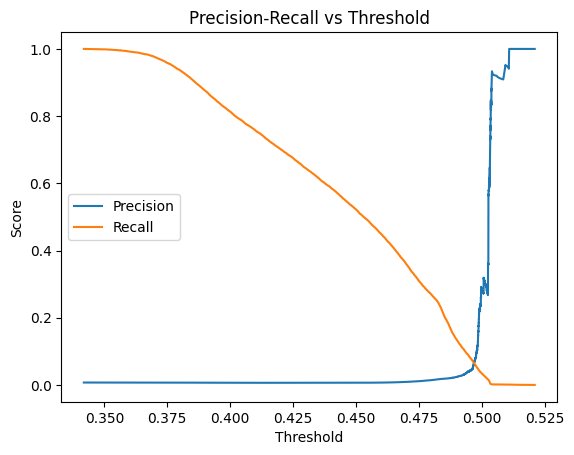

In [30]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Flatten labels and predictions (if padded)
true_labels = y_test.flatten()
predicted_probs = predictions.flatten()

# Exclude padded values (0)
valid_indices = true_labels != -1
true_labels = true_labels[valid_indices]
predicted_probs = predicted_probs[valid_indices]

precision, recall, thresholds = precision_recall_curve(true_labels, predicted_probs)

plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.show()


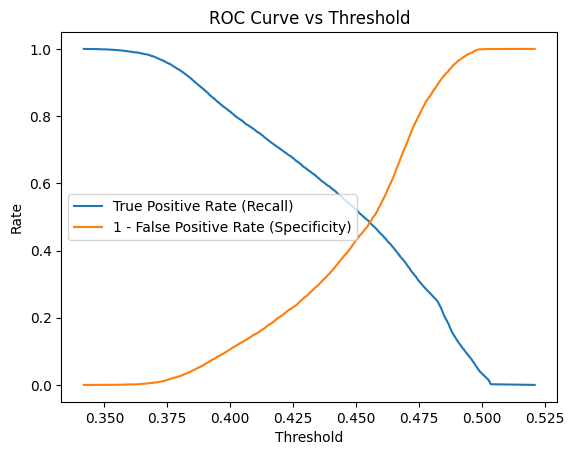

In [31]:
from sklearn.metrics import roc_curve

fpr, tpr, roc_thresholds = roc_curve(true_labels, predicted_probs)

plt.plot(roc_thresholds, tpr, label='True Positive Rate (Recall)')
plt.plot(roc_thresholds, 1 - fpr, label='1 - False Positive Rate (Specificity)')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('ROC Curve vs Threshold')
plt.legend()
plt.show()


In [32]:
binary_predictions = (predictions > 0.45).astype(int)

In [33]:
from sklearn.metrics import classification_report

# Flatten labels for metrics (if padded)
true_labels = y_test.flatten()
predicted_labels = binary_predictions.flatten()

# Exclude padded values (-1) from the metrics calculation
valid_indices = true_labels != -1
true_labels = true_labels[valid_indices]
predicted_labels = predicted_labels[valid_indices]

print(classification_report(true_labels, predicted_labels))


              precision    recall  f1-score   support

           0       0.99      0.43      0.60   2061906
           1       0.01      0.52      0.01     14925

    accuracy                           0.43   2076831
   macro avg       0.50      0.48      0.31   2076831
weighted avg       0.98      0.43      0.60   2076831



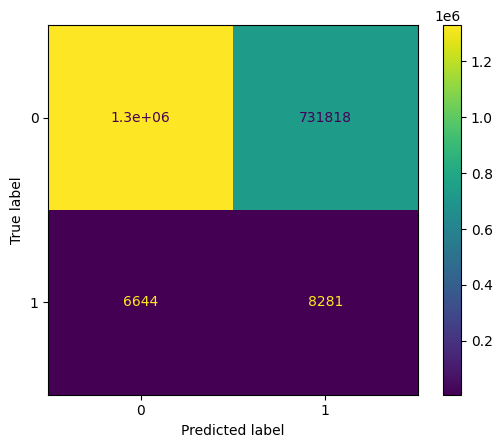

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

